In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from postprocessing import factuality

# Setup

In [3]:
SUMMARY_PATH = '../results/summaries'
VALID_RESPONSES_PATH = '../results/valid_responses'
FACTUALITY_RESPONSES_PATH = '../results/factuality'

PLOTS_PATH = '../results/plots'
io.validate_path(PLOTS_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

# Validity of Responses

In [5]:
# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)
df_summary.head(1)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,False,SiliconFlow,NaN,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,1,NaN,NaN,NaN,NaN,NaN,False,provider_error,API returned error response: Provider returned...,../data/data-temperature/temperature_0.0/confi...,False


In [6]:
def pick_row(group: io.pd.DataFrame) -> io.pd.Series:
    # If there is at least one True in Y
    if group["valid_attempt"].any():
        # keep only True rows, then take the one with smallest task_attempt
        g_true = group[group["valid_attempt"]]
        return g_true.loc[g_true['task_attempt'].idxmin()]
    else:
        # all False: take the row with largest task_attempt
        return group.loc[group["task_attempt"].idxmax()]

result = (
    df_summary
    .groupby(['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param'], group_keys=False)
    .apply(pick_row)
)

df_summary_unique = result.drop(columns=['model', 'temperature', 'grounded', 'date', 'time', 'task_name', 'task_param']).reset_index()
df_summary_unique.head(1)

/tmp/ipykernel_14911/2288030885.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_row)


,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,False,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,SiliconFlow,deepseek/deepseek-chat-v3.1,2,1140.0,479.0,1619.0,NaN,NaN,True,valid,Validation successful,../data/data-temperature/temperature_0.0/confi...,True


In [7]:
df_summary.shape, df_summary_unique.shape

((8640, 20), (5040, 20))

In [8]:
# Sanity check (all model-temperature pairs should have 30 samples
df_summary_unique.groupby(['model', 'temperature']).filter(lambda x: len(x) != 30)

,model,temperature,grounded,date,time,task_name,task_param,llm_provider,llm_model,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt


In [9]:
# check if there are models with missing temperature values
# considering only the experiment tasks
df_validity = df_summary_unique.query("task_name in @constants.EXPERIMENT_TASKS").copy()
_tmp = df_validity.groupby('model')['temperature'].apply(lambda x: len(set(x)) != len(constants.TEMPERATURE_VALUES))
_tmp.reset_index(name='missing_temperatures').query("missing_temperatures")

,model,missing_temperatures


In [10]:
# Check unique validity flags (across all calls)
df_validity.result_valid_flag.unique()

array(['valid', 'invalid', 'fixed', 'verbose', 'provider_error',
       'skipped-item', 'truncated-dict'], dtype=object)

In [11]:
# Summary: Percentage of valid vs invalid responses per model and temperature
group_columns = ['temperature', 'model', 'result_valid_flag']
df_validity_normalized = df_validity.copy()
df_validity_normalized = df_validity_normalized[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_validity_normalized['normalized_counts'] = df_validity_normalized['counts'] / df_validity_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_validity_normalized['result_valid_flag'] = io.pd.Categorical(df_validity_normalized['result_valid_flag'], categories=constants.EXPERIMENT_OUTPUTS_ORDER, ordered=True)
df_validity_normalized.head(10)

,temperature,model,result_valid_flag,counts,normalized_counts
0,0.0,deepseek-chat-v3.1,invalid,6,0.333333
1,0.0,deepseek-chat-v3.1,valid,12,0.666667
2,0.0,deepseek-r1-0528,invalid,4,0.222222
3,0.0,deepseek-r1-0528,valid,14,0.777778
4,0.0,gemini-2.5-flash,invalid,6,0.333333
5,0.0,gemini-2.5-flash,valid,12,0.666667
6,0.0,gemini-2.5-flash-grounded,invalid,8,0.444444
7,0.0,gemini-2.5-flash-grounded,valid,10,0.555556
8,0.0,gemini-2.5-pro,invalid,6,0.333333
9,0.0,gemini-2.5-pro,valid,12,0.666667


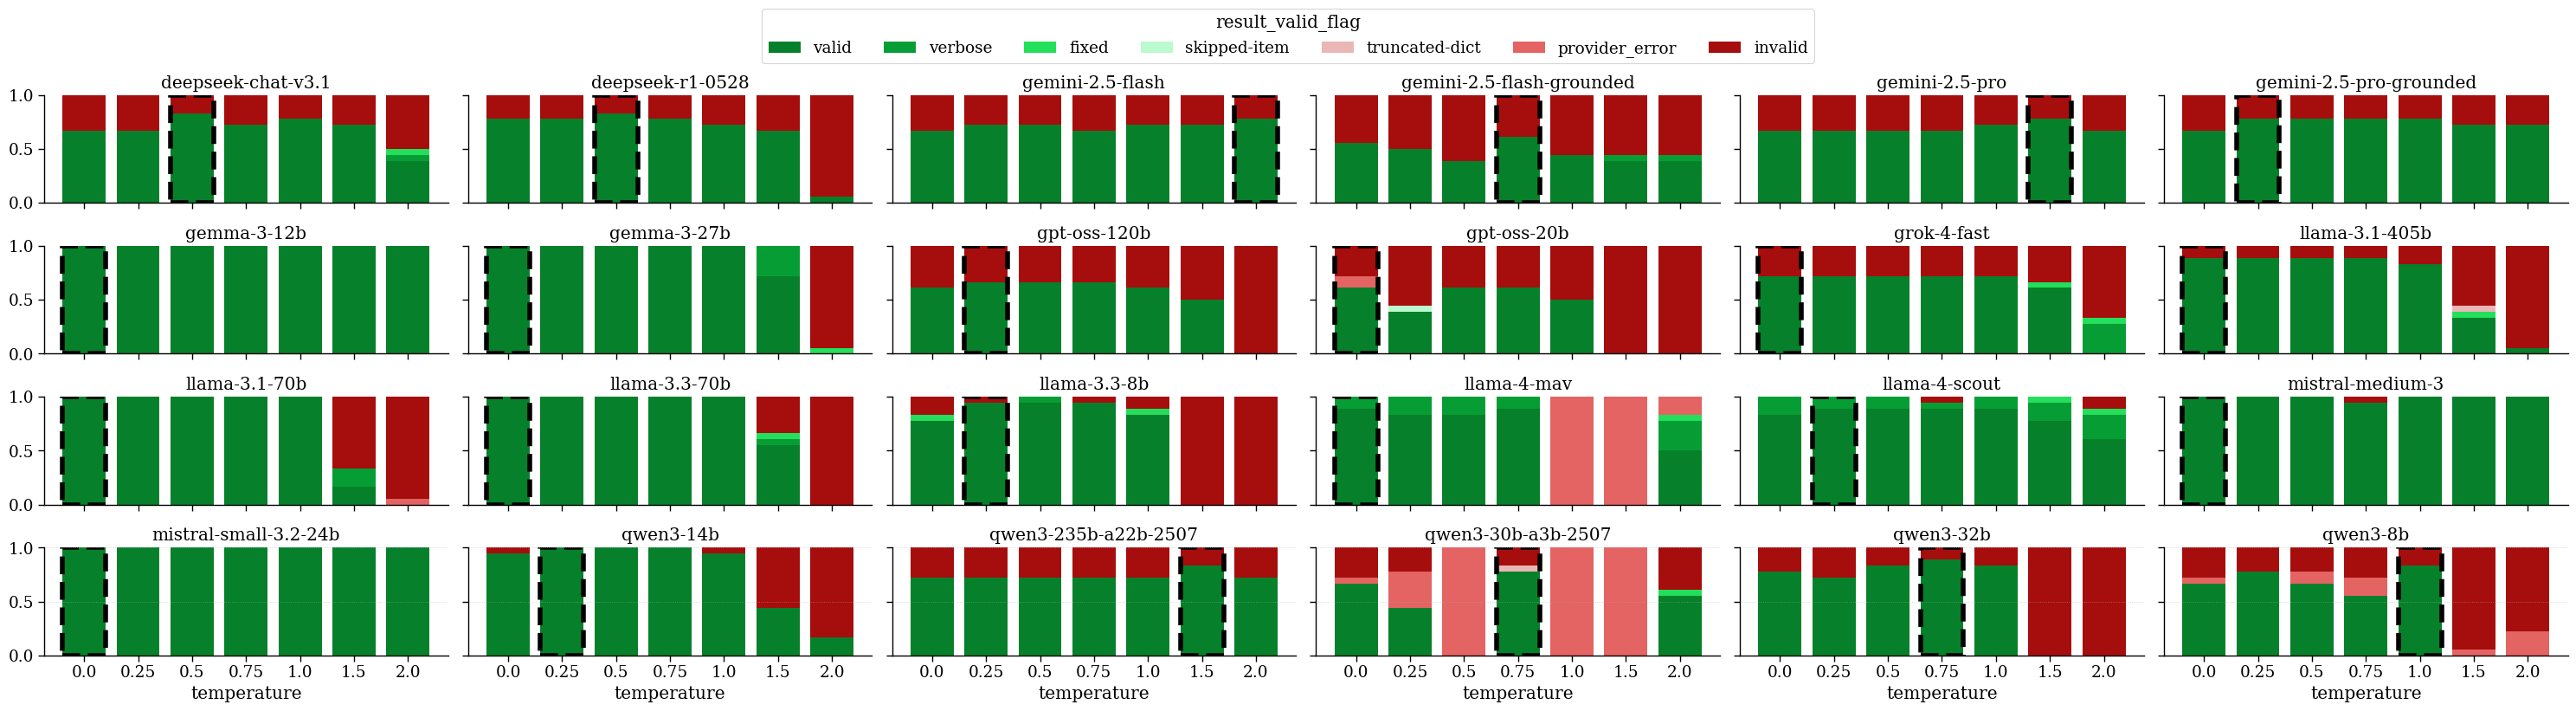

In [12]:
df = df_validity_normalized.copy()
groups = df.result_valid_flag.unique().categories

# prepare plotting
models = df['model'].unique()
n_models = len(models)

ncols = 6
nrows = int(vis.np.ceil(n_models / ncols))
width = 5. * ncols
height = 2. * nrows
fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)

if n_models == 1:
    axes = [axes]  # make iterable

for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        if idx >= n_models:
            fig.delaxes(axes[row, col])  # remove unused axes

        ax = axes[row, col]
        model = models[idx]
        sub = df[df['model'] == model]
        ax.set_title(model)

        # pivot to temperature × flag (values: normalized_counts), sort temperatures numerically
        pivot = (
            sub.pivot_table(
                index='temperature',
                columns='result_valid_flag',
                values='normalized_counts',
                aggfunc='sum',
                fill_value=0.0,
                observed=False
            )
            .reindex(columns=groups)
            .sort_index(key=lambda s: vis.pd.to_numeric(s, errors='coerce'))  # ensures numeric order
        )

        # choose a single best temperature: max 'a', ties → lowest temperature
        valid_series = pivot[constants.EXPERIMENT_OUTPUT_VALID] if constants.EXPERIMENT_OUTPUT_VALID in pivot.columns else vis.pd.Series(0.0, index=pivot.index)
        max_valid = valid_series.max()
        if vis.pd.isna(max_valid):
            best_idx = None
        else:
            best_idx = valid_series[valid_series == max_valid].index[0]  # first after numeric sort = lowest temp

        x = vis.np.arange(len(pivot.index))
        bottoms = vis.np.zeros(len(x), dtype=float)
        xtick_labels = pivot.index.tolist()

        # draw stacked bars
        bar_width = 0.8
        for flag in groups:
            vals = pivot[flag].to_numpy() if flag in pivot.columns else vis.np.zeros(len(x))
            ax.bar(x, vals, bottom=bottoms, width=bar_width, color=constants.EXPERIMENT_OUTPUT_COLORS[flag], edgecolor='none', label=flag)
            bottoms += vals

        # single rectangle around the chosen temperature, height = 1.0
        if best_idx is not None:
            j = vis.np.where(pivot.index == best_idx)[0][0]  # bar position
            rect = vis.plt.Rectangle((x[j] - bar_width/2, 0.0), 
                                 bar_width, 
                                 1.0,
                                 ls='--',
                                 fill=False, edgecolor='black', linewidth=4.0)
            ax.add_patch(rect)

        # y-limit to ensure the rectangle is fully visible up to 1.0
        ymax = max(1.0, float(bottoms.max()))
        ax.set_ylim(0.0, ymax)

# cosmetics
for ax in axes[-1,:]:
    ax.set_xlabel("temperature")
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index, rotation=0)
    ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# put a single legend at the top
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title="result_valid_flag", ncol=len(groups), loc='upper center', bbox_to_anchor=(0.5, 1.04))

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)
vis.plt.show()
vis.plt.close()

# Factuality

In [13]:
# Load the factuality data for each model
df_authors = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_RESPONSES_PATH, f"{model}_author.csv"), index_col=0) for model in constants.LLMS], ignore_index=True)
print(df_authors.shape[0])

# considering only the experiment tasks
df_authors = df_authors.query("task_name in @constants.EXPERIMENT_TASKS").copy()
print(df_authors.shape[0])

# set categorical ordering for task_name
df_authors['task_name'] = io.pd.Categorical(df_authors['task_name'], categories=constants.EXPERIMENT_TASKS, ordered=True)
df_authors.shape

143601
34966


(34966, 36)

In [14]:
df_fact_authors_either = factuality.get_factuality_authors_either_OA_APS(df_authors)
df_fact_authors_either.head(2)

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.942857,0.080812
1,deepseek-chat-v3.1,0.0,field,0.900000,0.000000


In [15]:
df_fact_authors_either.head(50)

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.00,top_k,0.942857,0.080812
1,deepseek-chat-v3.1,0.00,field,0.900000,0.000000
2,deepseek-chat-v3.1,0.00,epoch,0.970000,0.042426
3,deepseek-chat-v3.1,0.00,seniority,0.883333,0.023570
4,deepseek-chat-v3.1,0.00,twins,0.854167,0.139692
5,deepseek-chat-v3.1,0.25,top_k,0.957547,0.060037
6,deepseek-chat-v3.1,0.25,field,0.925000,0.035355
7,deepseek-chat-v3.1,0.25,epoch,0.934314,0.045754
8,deepseek-chat-v3.1,0.25,seniority,0.950000,0.000000
9,deepseek-chat-v3.1,0.25,twins,0.687500,0.458939


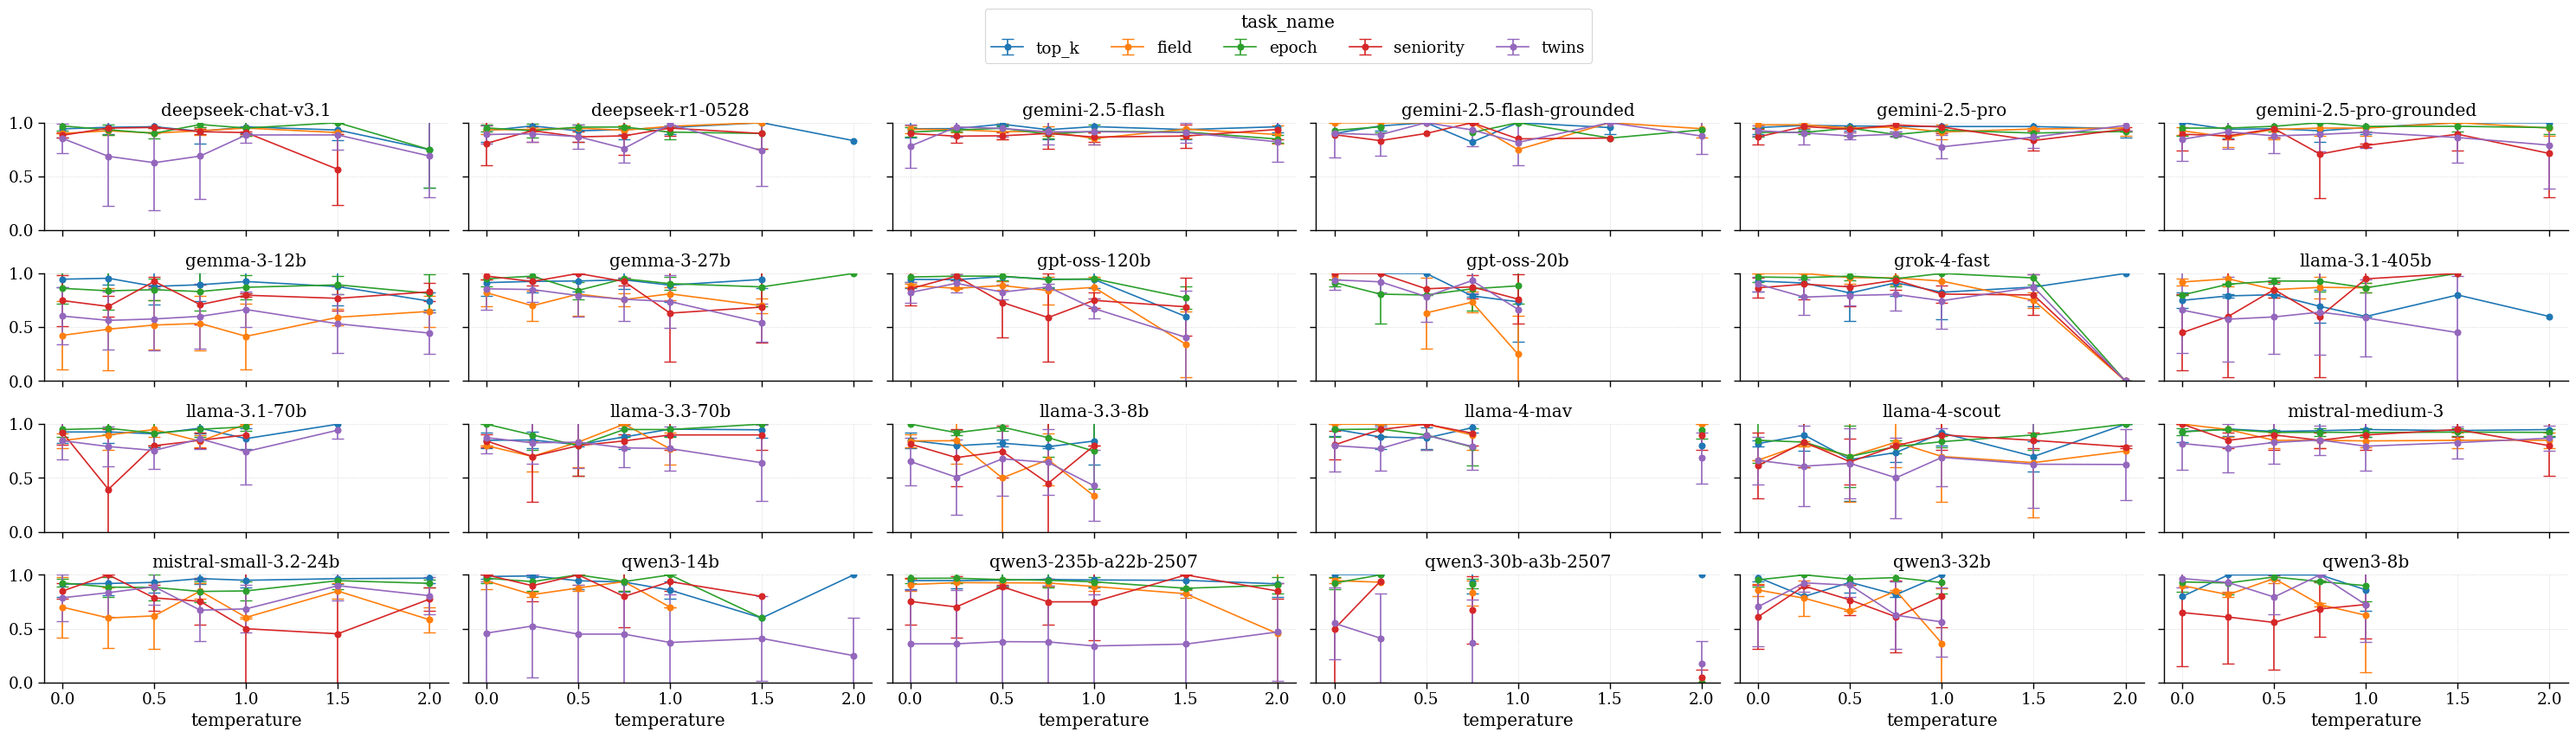

In [16]:
nmodels = df_fact_authors_either['model'].nunique()
ncols = 6
nrows = int(vis.np.ceil(nmodels / ncols))
width = 5. * ncols
height = 2. * nrows

fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)
groups = df_fact_authors_either.task_name.unique().categories

for idx, model in enumerate(df_fact_authors_either['model'].unique()):
    for task_name in constants.EXPERIMENT_TASKS:

        col = idx % ncols
        row = idx // ncols
        ax = axes[row, col]

        df_subplot = df_fact_authors_either.query("model == @model and task_name == @task_name").copy()

        ax.set_title(model)
        ax.errorbar(df_subplot['temperature'], df_subplot['mean'], yerr=df_subplot['std'], fmt='o-', capsize=5, label=task_name)
        ax.set_ylim(0, 1)
        ax.grid(linestyle=':', linewidth=0.6, alpha=0.6)

# cosmetics
for ax in axes[-1,:]:
    ax.set_xlabel("temperature")
    ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# put a single legend at the top
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, title="task_name", ncol=len(groups), loc='upper center', bbox_to_anchor=(0.5, 1.08))

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)
vis.plt.show()
vis.plt.close()


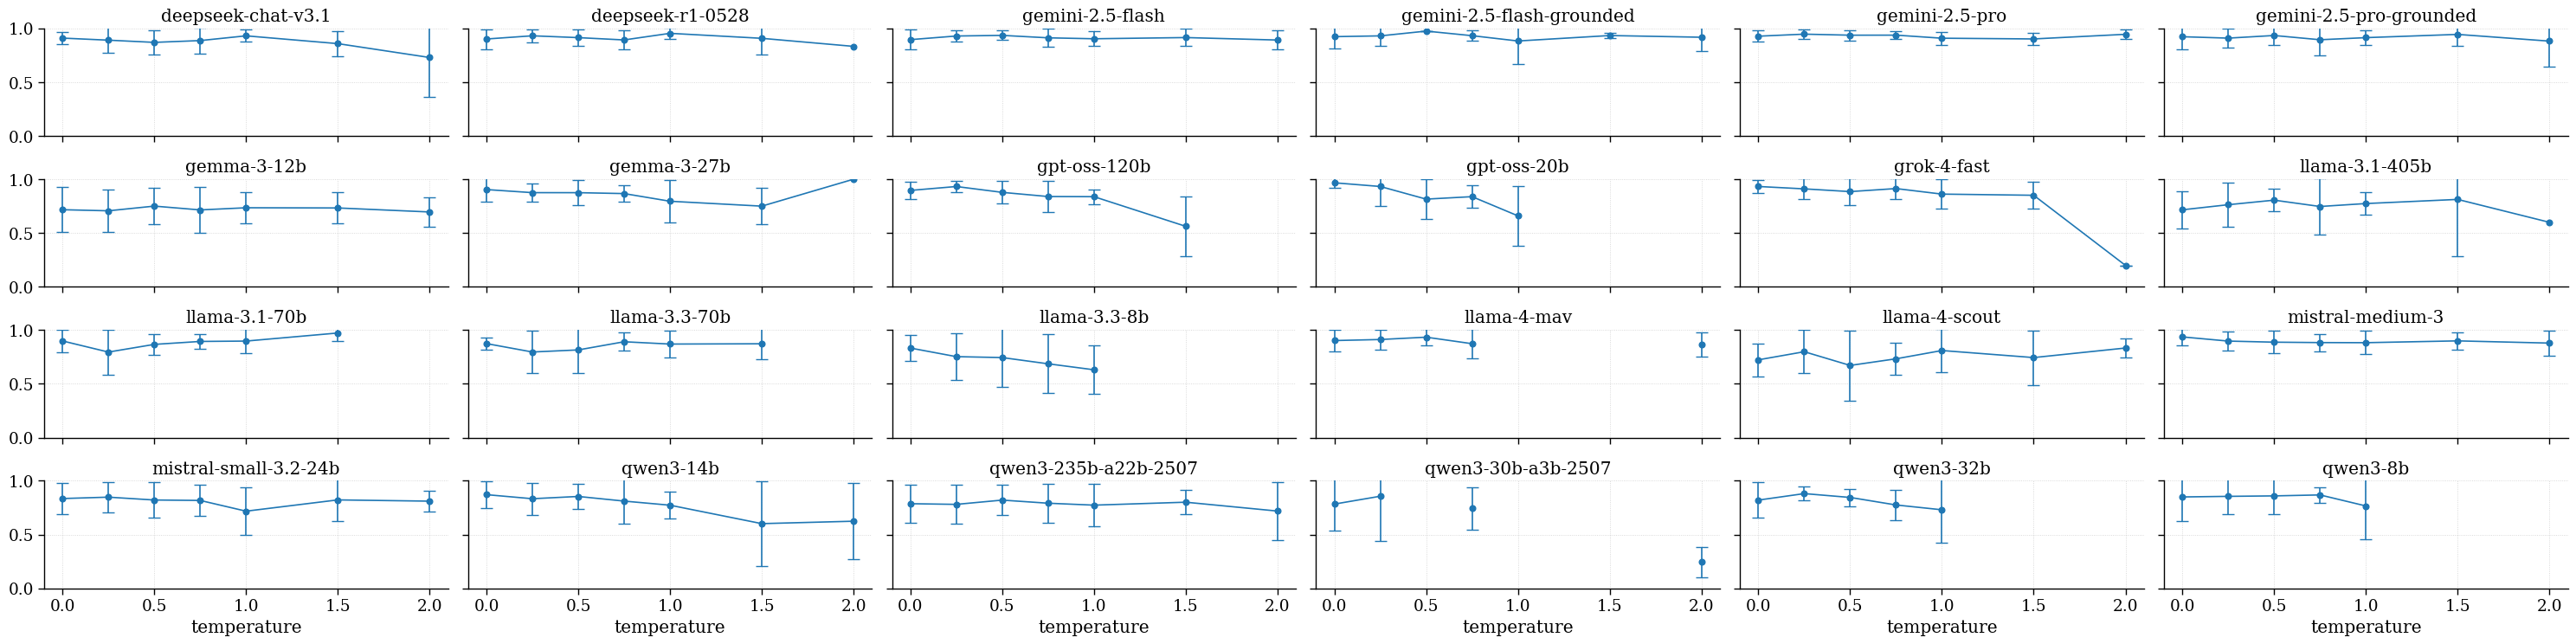

In [17]:
nmodels = df_fact_authors_either['model'].nunique()
ncols = 6
nrows = int(vis.np.ceil(nmodels / ncols))
width = 5. * ncols
height = 2. * nrows

fig, axes = vis.plt.subplots(nrows, ncols, figsize=(width, height), sharex=True, sharey=True)
df_grouped = df_fact_authors_either.groupby(['model','temperature'])[['mean','std']].mean().reset_index()

for idx, model in enumerate(df_grouped['model'].unique()):
    
    col = idx % ncols
    row = idx // ncols
    ax = axes[row, col]

    df_subplot = df_grouped.query("model == @model").copy()

    ax.set_title(model)
    ax.errorbar(df_subplot['temperature'], df_subplot['mean'], yerr=df_subplot['std'], fmt='o-', capsize=5, label=task_name)
    
    ax.set_ylim(0, 1)
    ax.grid(linestyle=':', linewidth=0.6, alpha=0.6)

# cosmetics
for ax in axes[-1,:]:
    ax.set_xlabel("temperature")
    ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.6)

# final
vis.plt.tight_layout(rect=[0,0,1,0.96])
vis.plt.subplots_adjust(hspace=0.4, wspace=0.05)
vis.plt.show()
vis.plt.close()


In [28]:
df_fact_authors_either.head()

,model,temperature,task_name,mean,std
0,deepseek-chat-v3.1,0.0,top_k,0.942857,0.080812
1,deepseek-chat-v3.1,0.0,field,0.900000,0.000000
2,deepseek-chat-v3.1,0.0,epoch,0.970000,0.042426
3,deepseek-chat-v3.1,0.0,seniority,0.883333,0.023570
4,deepseek-chat-v3.1,0.0,twins,0.854167,0.139692


In [29]:
df_best_temperature_by_factuality = df_fact_authors_either.groupby(["model", "temperature"])[["mean", "std"]].mean().reset_index()
    
epsilon = 1e-100
df_best_temperature_by_factuality["score"] = df_best_temperature_by_factuality["mean"] / df_best_temperature_by_factuality["std"].replace(0, epsilon)


df_best_temperature_by_factuality

,model,temperature,mean,std,score
0,deepseek-chat-v3.1,0.00,0.910071,0.057300,15.882520
1,deepseek-chat-v3.1,0.25,0.890872,0.120017,7.422875
2,deepseek-chat-v3.1,0.50,0.870378,0.111303,7.819897
3,deepseek-chat-v3.1,0.75,0.887071,0.119151,7.444907
4,deepseek-chat-v3.1,1.00,0.931046,0.056996,16.335199
...,...,...,...,...,...
163,qwen3-8b,0.50,0.860043,0.168398,5.107212
164,qwen3-8b,0.75,0.868976,0.070556,12.316148
165,qwen3-8b,1.00,0.766655,0.306693,2.499749
166,qwen3-8b,1.50,NaN,NaN,NaN


In [32]:
df_fact_authors_either.query("model=='deepseek-r1-0528' and temperature==2.0")

,model,temperature,task_name,mean,std
65,deepseek-r1-0528,2.0,top_k,0.833333,NaN
66,deepseek-r1-0528,2.0,field,NaN,NaN
67,deepseek-r1-0528,2.0,epoch,NaN,NaN
68,deepseek-r1-0528,2.0,seniority,NaN,NaN
69,deepseek-r1-0528,2.0,twins,NaN,NaN


In [20]:
for model, df in df_best_temperature_by_factuality.groupby('model'):
    print(model)
    print(df[['temperature', 'mean', 'std', 'score']])
    print('--')

deepseek-chat-v3.1
   temperature      mean       std      score
0         0.00  0.910071  0.057300  15.882520
1         0.25  0.890872  0.120017   7.422875
2         0.50  0.870378  0.111303   7.819897
3         0.75  0.887071  0.119151   7.444907
4         1.00  0.931046  0.056996  16.335199
5         1.50  0.858724  0.115047   7.464141
6         2.00  0.730000  0.362850   2.011848
--
deepseek-r1-0528
    temperature      mean       std      score
7          0.00  0.901737  0.092799   9.717044
8          0.25  0.931446  0.060074  15.505063
9          0.50  0.914457  0.072815  12.558601
10         0.75  0.893056  0.089163  10.015945
11         1.00  0.954343  0.054975  17.359567
12         1.50  0.908000  0.152392   5.958309
13         2.00  0.833333       NaN        NaN
--
gemini-2.5-flash
    temperature      mean       std      score
14         0.00  0.895868  0.090869   9.858877
15         0.25  0.929425  0.052032  17.862466
16         0.50  0.935260  0.044983  20.791527
17       

In [21]:

# Sort: first by model, then by descending score, then by ascending temperature
df_best_temperature_by_factuality = df_best_temperature_by_factuality.sort_values(["model", "score", "temperature"], ascending=[True, False, True])

# Pick the best row per model
df_best_temperature_by_factuality = df_best_temperature_by_factuality.groupby("model").first().reset_index()
df_best_temperature_by_factuality #.sort_values('temperature')


,model,temperature,mean,std,score
0,deepseek-chat-v3.1,1.00,0.931046,0.056996,1.633520e+01
1,deepseek-r1-0528,1.00,0.954343,0.054975,1.735957e+01
2,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01
3,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99
4,gemini-2.5-pro,0.75,0.937524,0.035024,2.676798e+01
5,gemini-2.5-pro-grounded,1.00,0.914280,0.068320,1.338238e+01
6,gemma-3-12b,1.00,0.734982,0.140855,5.217993e+00
7,gemma-3-27b,0.75,0.866651,0.075943,1.141194e+01
8,gpt-oss-120b,0.25,0.932246,0.048622,1.917335e+01
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01


In [22]:
df_best_temperature_by_factuality.sort_values('temperature')

,model,temperature,mean,std,score
13,llama-3.3-70b,0.00,0.873889,0.055484,1.575027e+01
14,llama-3.3-8b,0.00,0.832407,0.118015,7.053426e+00
9,gpt-oss-20b,0.00,0.966688,0.050585,1.911033e+01
17,mistral-medium-3,0.00,0.936005,0.074931,1.249159e+01
22,qwen3-32b,0.25,0.881270,0.065768,1.339963e+01
8,gpt-oss-120b,0.25,0.932246,0.048622,1.917335e+01
3,gemini-2.5-flash-grounded,0.50,0.975000,0.000000,9.750000e+99
2,gemini-2.5-flash,0.50,0.935260,0.044983,2.079153e+01
11,llama-3.1-405b,0.50,0.805605,0.103340,7.795670e+00
19,qwen3-14b,0.50,0.854871,0.113410,7.537863e+00


# Bias